In [1]:

import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.15.0


In [2]:
!nvidia-smi


Thu Feb 29 06:41:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2024-02-29 06:41:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-29 06:41:34 (84.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:

# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-02-29 06:41:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 142.250.4.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.7MB/s    in 8.1s    

2024-02-29 06:41:44 (19.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
walk_through_dir("10_food_classes_10_percent")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/gri

In [6]:

# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [7]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
train_data_10_percent.class_names


['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

Model 0: Building a transfer learning model using the Keras Functional API


In [23]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB7(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=25,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract"),
                                            early_stopping])


Shape after base_model: (None, 7, 7, 2560)
After GlobalAveragePooling2D(): (None, 2560)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20240229-065048
Epoch 1/25
24/24 [==============================] - 50s 892ms/step - loss: 1.6266 - accuracy: 0.5627 - val_loss: 0.9982 - val_accuracy: 0.7747
Epoch 2/25
24/24 [==============================] - 16s 646ms/step - loss: 0.8204 - accuracy: 0.8093 - val_loss: 0.7123 - val_accuracy: 0.8158
Epoch 3/25
24/24 [==============================] - 16s 644ms/step - loss: 0.6290 - accuracy: 0.8440 - val_loss: 0.6386 - val_accuracy: 0.8273
Epoch 4/25
24/24 [==============================] - 16s 653ms/step - loss: 0.5298 - accuracy: 0.8600 - val_loss: 0.5914 - val_accuracy: 0.8322
Epoch 5/25
24/24 [==============================] - 16s 651ms/step - loss: 0.4626 - accuracy: 0.8800 - val_loss: 0.5759 - val_accuracy: 0.8355
Epoch 6/25
24/24 [==============================] - 16s 655ms/step - loss: 0.3998 - accuracy: 0.9080 - 

In [24]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


In [ ]:
plot_loss_curves(history_10_percent)

79/79 [==============================] - 34s 347ms/step
Precision: 0.11006745572098578
Recall: 0.1096
F1 Score: 0.1097101742730402
Confusion Matrix:
 [[32 17 21 35 24 28 21 24 22 26]
 [28 30 29 32 21 21 20 23 28 18]
 [19 21 24 24 23 31 31 23 31 23]
 [23 33 15 28 35 16 30 27 21 22]
 [27 25 26 30 25 29 18 23 25 22]
 [21 21 36 32 24 26 22 25 19 24]
 [24 30 31 26 17 24 24 33 26 15]
 [28 28 27 24 21 20 28 27 21 26]
 [26 20 25 29 26 22 27 18 33 24]
 [19 21 30 37 24 32 25 18 19 25]]


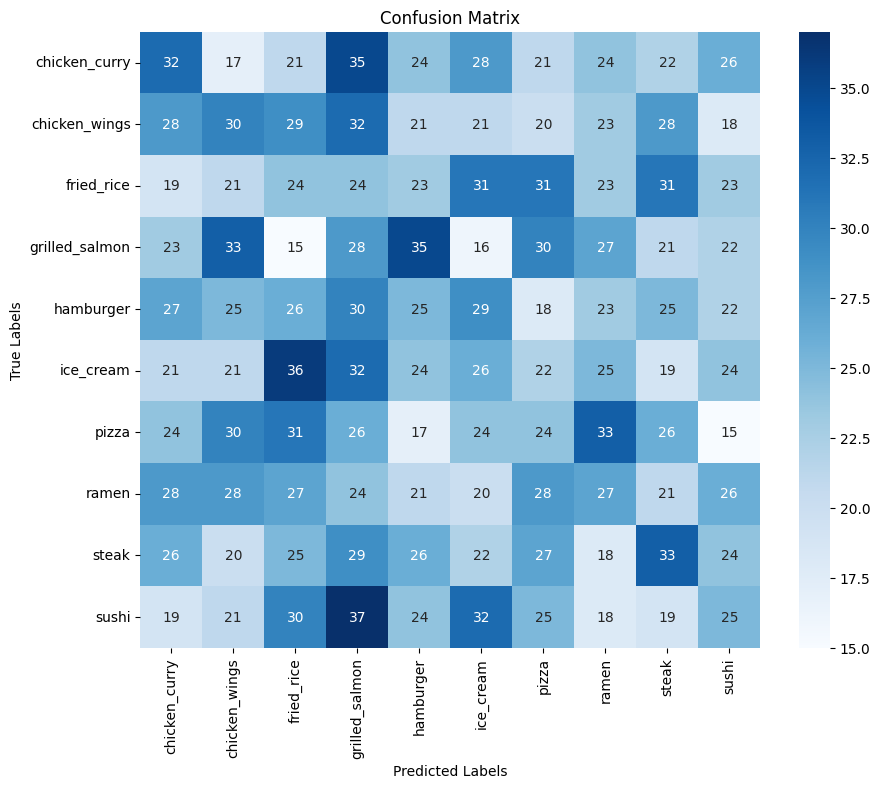

In [26]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_metrics_and_plot_confusion_matrix(model, test_data, class_names):
    # Predict probabilities for the test set
    y_probs = model.predict(test_data)
    # Predict labels for the test set
    y_preds = np.argmax(y_probs, axis=1)

    # Get true labels
    true_labels = []
    for _, y_true in test_data.unbatch():
        true_labels.append(y_true.numpy().argmax())

    # Calculate precision
    precision = precision_score(true_labels, y_preds, average='macro')
    # Calculate recall
    recall = recall_score(true_labels, y_preds, average='macro')
    # Calculate F1 score
    f1 = f1_score(true_labels, y_preds, average='macro')
    # Calculate confusion matrix
    conf_mat = confusion_matrix(true_labels, y_preds)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_mat)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Usage example:
results_0 = calculate_metrics_and_plot_confusion_matrix(model_0, test_data_10_percent, train_data_10_percent.class_names)
results_0

Running a series of transfer learning experiments
We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:

Model 1: Use feature extraction transfer learning on 1% of the training data with data augmentation. <br>
Model 2: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint. <br>
Model 3: Fine-tune the Model 2 checkpoint on 10% of the training data with data augmentation. <br>
Model 4: Fine-tune the Model 2 checkpoint on 100% of the training data with data augmentation.

In [28]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2024-02-29 06:59:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  23.1MB/s    in 6.7s    

2024-02-29 06:59:33 (19.1 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [29]:
walk_through_dir("10_food_classes_1_percent")


There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'

In [30]:

import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [31]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.4),
  layers.RandomZoom(0.4),
  layers.RandomHeight(0.4),
  layers.RandomWidth(0.4),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")


In [32]:
data_augmentation

Model 1: Feature extraction transfer learning on 1% of the data with data augmentation


In [33]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model =  tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate =  0.01),
              metrics=["accuracy"])

# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))


# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=25,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug"),
                               early_stopping])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240229-070001
Epoch 1/25
3/3 [==============================] - 45s 10s/step - loss: 2.2573 - accuracy: 0.1571 - val_loss: 1.6305 - val_accuracy: 0.3964
Epoch 2/25
3/3 [==============================] - 15s 7s/step - loss: 1.0547 - accuracy: 0.6857 - val_loss: 1.2463 - val_accuracy: 0.5592
Epoch 3/25
3/3 [==============================] - 18s 7s/step - loss: 0.6333 - accuracy: 0.8286 - val_loss: 1.1070 - val_accuracy: 0.6398
Epoch 4/25
3/3 [==============================] - 17s 7s/step - loss: 0.4831 - accuracy: 0.8714 - val_loss: 1.1817 - val_accuracy: 0.6184
Epoch 5/25
3/3 [==============================] - 18s 8s/step - loss: 0.3934 - accuracy: 0.8571 - val_loss: 1.1413 - val_accuracy: 0.6266
Epoch 6/25
3/3 [==============================] - 18s 8s/step - loss: 0.2935 - accuracy: 0.8714 - val_loss: 1.1774 - val_accuracy: 0.6151
Epoch 7/25
3/3 [==============================] - 16s 7s/step - loss: 0.3718 - accura

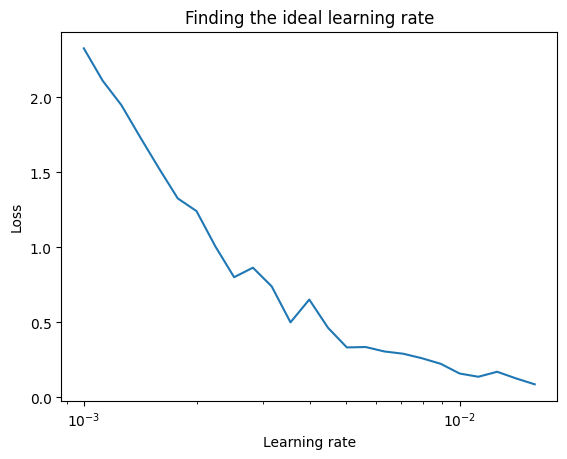

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
lrs = 1e-3 * (10**(np.arange(25)/20))
plt.semilogx(lrs, history_1_percent.history["loss"]) # want the x-axis to be log-scale
plt.xlabel("Learning rate")

plt.ylabel("Loss")
plt.title("Finding the ideal learning rate");

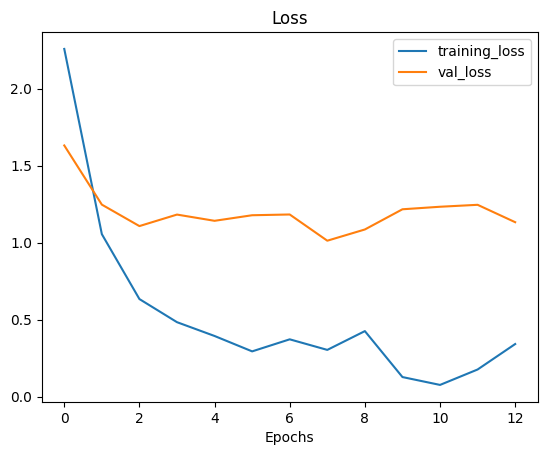

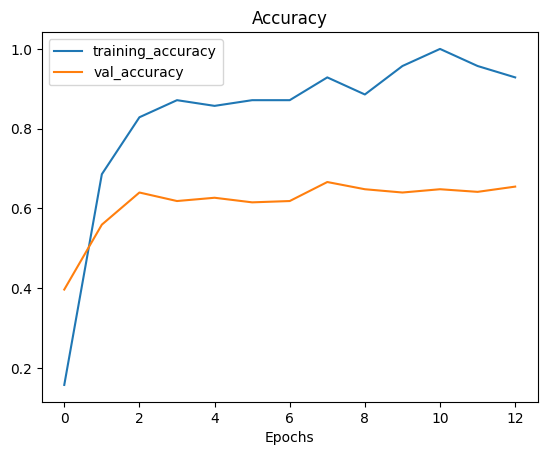

In [34]:
plot_loss_curves(history_1_percent)


79/79 [==============================] - 34s 347ms/step
Precision: 0.11532461176924025
Recall: 0.11240000000000001
F1 Score: 0.1092488338306196
Confusion Matrix:
 [[23 27 19 20 34 20 28 13 49 17]
 [33 23 21 28 37 29 20  7 33 19]
 [38 29 27 21 30 26 23  7 32 17]
 [35 18 32 30 25 19 22  6 51 12]
 [33 31 16 25 40 24 26  1 38 16]
 [23 22 20 31 33 26 28 11 43 13]
 [24 27  9 27 29 29 30  7 53 15]
 [27 20 22 30 27 20 30 13 44 17]
 [33 17 27 29 30 23 22  9 51  9]
 [26 21 19 27 38 23 35 10 33 18]]


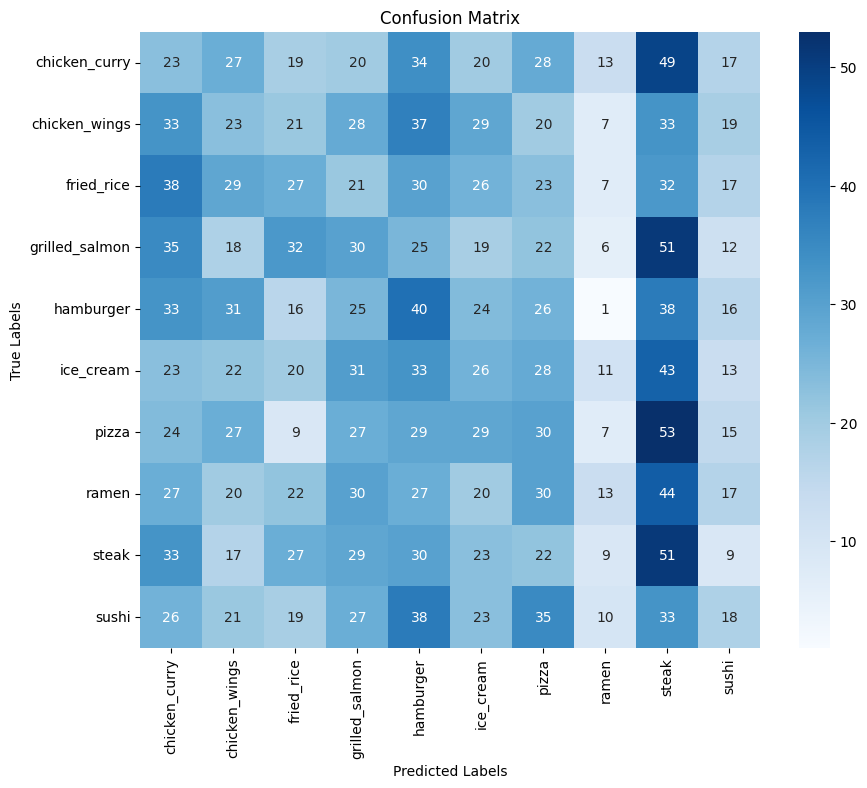

In [35]:
results_1 = calculate_metrics_and_plot_confusion_matrix(model_1, test_data, train_data_1_percent.class_names)
results_1

Model 2: Feature extraction transfer learning with 10% of data and data augmentation


In [40]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test"

In [41]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [42]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing # OLD

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

## OLD
# # Build data augmentation layer
# data_augmentation = Sequential([
#   preprocessing.RandomFlip('horizontal'),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomRotation(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
# ], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

24274472/24274472 [==============================] - 2s 0us/step


In [43]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()

In [44]:

# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [45]:

# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240229-070639
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0107 - accuracy: 0.3347
Epoch 1: val_loss improved from inf to 1.52682, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 43s 1s/step - loss: 2.0107 - accuracy: 0.3347 - val_loss: 1.5268 - val_accuracy: 0.6316
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4108 - accuracy: 0.6547
Epoch 2: val_loss improved from 1.52682 to 1.07024, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 25s 1s/step - loss: 1.4108 - accuracy: 0.6547 - val_loss: 1.0702 - val_accuracy: 0.7319
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0852 - accuracy: 0.7467
Epoch 3: val_loss improved from 1.07024 to 0.86790, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=======

In [46]:

# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 10s 122ms/step - loss: 0.6697 - accuracy: 0.8284


[0.6696628928184509, 0.8284000158309937]

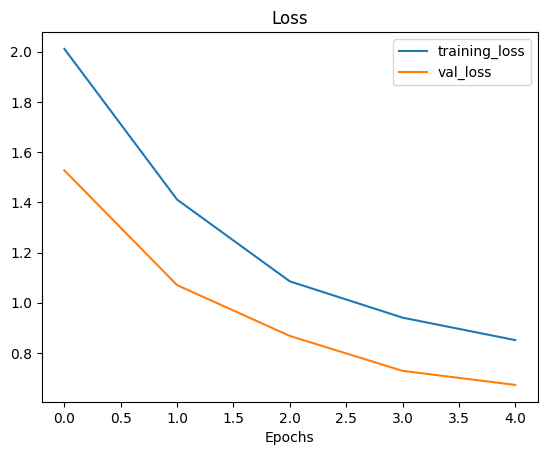

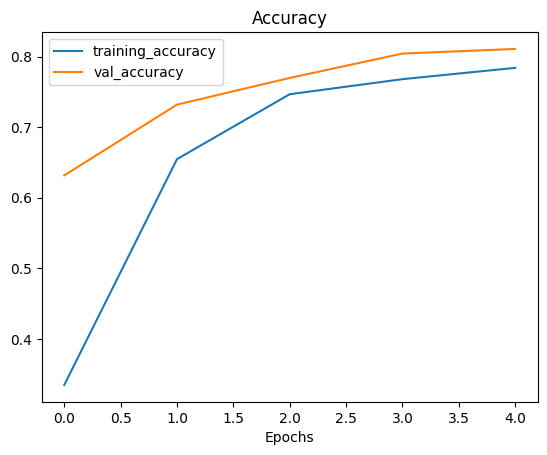

In [47]:
plot_loss_curves(history_10_percent_data_aug)


In [48]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 8s 90ms/step - loss: 0.6697 - accuracy: 0.8284


In [49]:
results_10_percent_data_aug == loaded_weights_model_results


False

Model 3: Fine-tuning an existing model on 10% of the data


In [50]:
# Access the base_model layers of model_2
model_2_base_model = model_2.layers[2]
model_2_base_model.name

'efficientnetv2-b0'

In [51]:
# Make all the layers in model_2_base_model trainable
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

# Recompile the whole model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [52]:
model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [53]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240229-071038
Epoch 5/10
24/24 [==============================] - 33s 945ms/step - loss: 0.7129 - accuracy: 0.8120 - val_loss: 0.5249 - val_accuracy: 0.8141
Epoch 6/10
24/24 [==============================] - 22s 936ms/step - loss: 0.5936 - accuracy: 0.8160 - val_loss: 0.4723 - val_accuracy: 0.8339
Epoch 7/10
24/24 [==============================] - 20s 800ms/step - loss: 0.5461 - accuracy: 0.8347 - val_loss: 0.4761 - val_accuracy: 0.8158
Epoch 8/10
24/24 [==============================] - 22s 872ms/step - loss: 0.5220 - accuracy: 0.8427 - val_loss: 0.4647 - val_accuracy: 0.8240
Epoch 9/10
24/24 [==============================] - 20s 839ms/step - loss: 0.4802 - accuracy: 0.8453 - val_loss: 0.4881 - val_accuracy: 0.8240
Epoch 10/10
24/24 [==============================] - 14s 518ms/step - loss: 0.4374 - accuracy: 0.8547 - val_loss: 0.4734 - val_accuracy: 0.8421


In [54]:
results_fine_tune_10_percent = model_2.evaluate(test_data)


79/79 [==============================] - 5s 62ms/step - loss: 0.4382 - accuracy: 0.8532


In [55]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


5
11
[0.3346666693687439, 0.6546666622161865, 0.746666669845581, 0.7680000066757202, 0.7839999794960022, 0.8119999766349792, 0.8159999847412109, 0.8346666693687439, 0.8426666855812073, 0.8453333377838135, 0.8546666502952576]


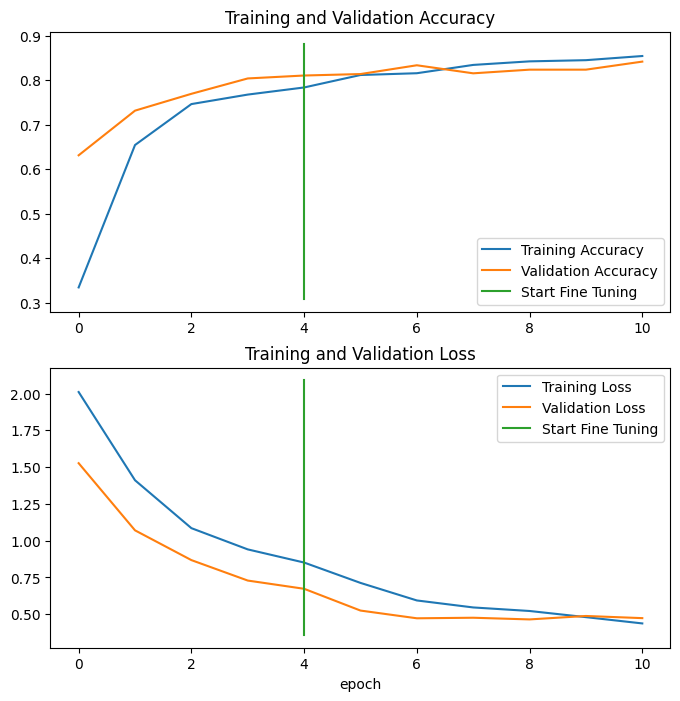

In [56]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

Model 4: Fine-tuning an existing model all of the data


In [82]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2024-02-29 07:42:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 142.250.4.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  22.1MB/s    in 24s     

2024-02-29 07:43:20 (20.3 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [83]:

# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [84]:
model_2.evaluate(test_data)


79/79 [==============================] - 10s 117ms/step - loss: 0.2736 - accuracy: 0.9120


[0.2736469507217407, 0.9120000004768372]

In [85]:
model_2 = create_base_model(learning_rate=0.0001) # 10x lower learning rate for fine-tuning


In [86]:
model_2.load_weights(checkpoint_path)


In [87]:
model_2.evaluate(test_data)


79/79 [==============================] - 14s 88ms/step - loss: 0.6697 - accuracy: 0.8284


[0.6696630120277405, 0.8284000158309937]

In [88]:

# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [89]:
# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [91]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=50,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10"),
                                                      early_stopping])


Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20240229-074429
Epoch 1/50
235/235 [==============================] - 66s 276ms/step - loss: 0.7168 - accuracy: 0.7721 - val_loss: 0.3664 - val_accuracy: 0.8618
Epoch 2/50
235/235 [==============================] - 51s 216ms/step - loss: 0.6024 - accuracy: 0.8113 - val_loss: 0.2817 - val_accuracy: 0.8964
Epoch 3/50
235/235 [==============================] - 56s 237ms/step - loss: 0.5368 - accuracy: 0.8325 - val_loss: 0.2706 - val_accuracy: 0.9046
Epoch 4/50
235/235 [==============================] - 48s 203ms/step - loss: 0.5054 - accuracy: 0.8375 - val_loss: 0.2599 - val_accuracy: 0.9128
Epoch 5/50
235/235 [==============================] - 46s 196ms/step - loss: 0.4853 - accuracy: 0.8441 - val_loss: 0.2620 - val_accuracy: 0.9062
Epoch 6/50
235/235 [==============================] - 44s 184ms/step - loss: 0.4567 - accuracy: 0.8531 - val_loss: 0.2313 - val_accuracy: 0.9161
Epoch 7/50
235/235 [=========

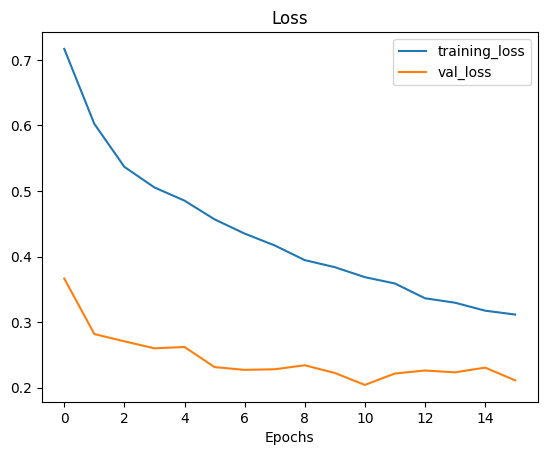

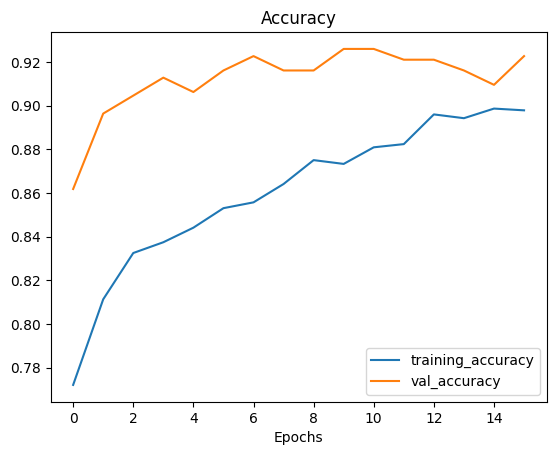

In [93]:
plot_loss_curves(history_fine_10_classes_full)

In [66]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 5s 63ms/step - loss: 0.2736 - accuracy: 0.9120


[0.2736469805240631, 0.9120000004768372]

5
21
[0.3346666693687439, 0.6546666622161865, 0.746666669845581, 0.7680000066757202, 0.7839999794960022, 0.7721333503723145, 0.8113333582878113, 0.8325333595275879, 0.8374666571617126, 0.8441333174705505, 0.8530666828155518, 0.855733335018158, 0.864133358001709, 0.8750666379928589, 0.8733333349227905, 0.8809333443641663, 0.8823999762535095, 0.8960000276565552, 0.894266664981842, 0.8986666798591614, 0.8978666663169861]


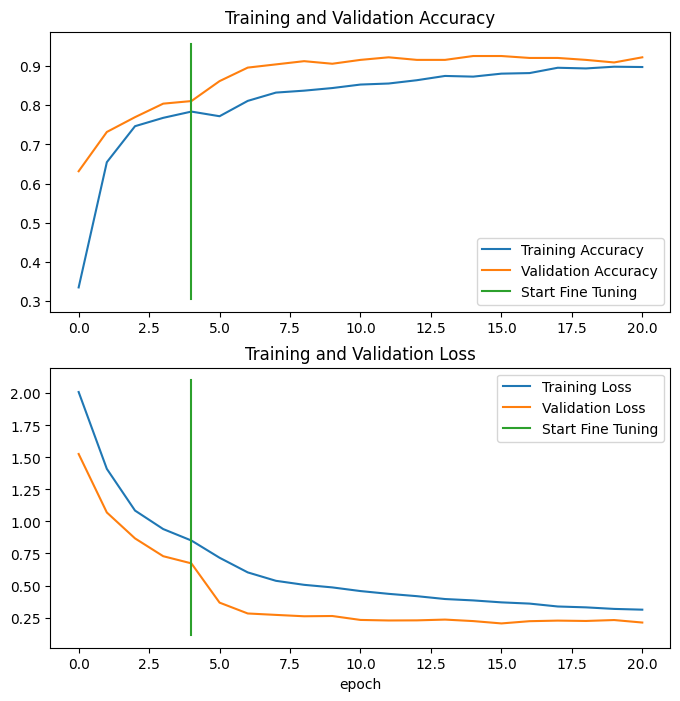

In [94]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

Viewing our experiment data on TensorBoard


In [95]:


# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished

2024-02-29 07:57:12.494951: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 07:57:12.495024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 07:57:12.496610: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 07:57:14.199082: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb

In [98]:
pip install -U tensorboard


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 34.6 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.16.2 which is incompatible.


In [100]:
import mlflow

# Start MLflow run
mlflow.start_run()


<ActiveRun: >